# Численное исследование характеристик канала между RFID-считывателем и меткой в номере машины

## Подготовка ноутбука
Импортируем все необходимые библиотеки, настроим флаги и константы, которыми будем пользоваться в эксперименте, и определим служебные функции, чтобы не отвлекаться на них в расчетной части эксперимента.

In [3]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

In [4]:
import os

import locale

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches

from tabulate import tabulate
from tqdm.notebook import tqdm

from itertools import product
from collections import namedtuple
from copy import deepcopy
import time
import numpy as np
import pandas as pd
from typing import Sequence, Tuple, Optional, Union

# Подключаем локальные пакеты
import pyons
from pyons.models.rfid import pyradise
from pyons.models.rfid.pyradise import w2dbm, dbm2w, db2lin

In [5]:
# Настраиваем matplotlib
%matplotlib inline
CMAP_NAME = 'inferno'  # Цветовая схема для графиков

matplotlib.rcParams.update({
    'image.cmap': CMAP_NAME,
    'axes.formatter.use_locale': True,
    'font.size': 16,
    'font.family': 'sans-serif',
    
    # Шрифт PT Serif Caption можно установить с Google Fonts.
    # После установки шрифта нужно удалить кэш matplitlib,
    # на Ubuntu: ~/.cache/matplotlib 
    'font.sans-serif': ['PT Serif Caption'],
})

locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8')

'ru_RU.UTF-8'

Определим переменные окружения, которые будут использоваться в эксперименте.

In [6]:
def get_color(x):
    """
    Получить цвет из текущей карты.
    """
    return cm.get_cmap(CMAP_NAME)(x)

## Параметры окружения

In [7]:
FREQUENCY = 860_000_000
SPEED_OF_LIGHT = 299_792_458
WAVELEN = SPEED_OF_LIGHT / FREQUENCY
THERMAL_NOISE = -114.0  # dBm

VERTICAL_POLARIZATION = 0.0
HORIZONTAL_POLARIZATION = 1.0
CIRCULAR_POLARIZATION = 0.5

# DIR_THETA = forward direction
# DIR_PHI = right direction

READER_POS = np.array((0, 1.75, 5.0))
READER_ANGLE = np.pi / 4
READER_FORWARD = np.array((np.sin(READER_ANGLE), 0, -np.cos(READER_ANGLE)))
READER_RIGHT = np.array((0, 1, 0))
READER_POLARIZATION = CIRCULAR_POLARIZATION
READER_GAIN = 8
READER_CABLE_LOSS = -2.0
READER_NOISE = -80.0  # dBm
READER_TX_POWER = 31.5  # dBm
READER_SENSITIVITY = -80.0  # dBm

TAG_POS = np.array((5, 1.75, 0.5))
TAG_FORWARD = np.array((-1, 0, 0))
TAG_RIGHT = np.array((0, -1, 0))
TAG_POLARIZATION = HORIZONTAL_POLARIZATION
TAG_SENSITIVITY = -18.0
TAG_GAIN = 2.0
TAG_BACKSCATTER_LOSS = -10.0

PERMITTIVITY = 15
CONDUCTIVITY = 0.03
REFLECTION = pyradise.reflection
RP = pyradise.dipole_rp

DR = 8
RTCAL_MUL = 3
TRCAL_MUL = 2

Определим вспомогательные функции для конвертации единиц измерения:

- `deg2rad()` - градусы в радианы
- `kmph2mps()` - километры в час в метры в секунду

In [8]:
def deg2rad(a: float) -> float:
    """Перевести угол из градусов в радианы."""
    return a / 180.0 * np.pi

def kmph2mps(x: float) -> float:
    """Перевести км/ч в м/с"""
    return x * 5 / 18

Вспомогательная функция для сохранения последнего графика в файлы.

In [9]:
IMAGE_BASE_DIR = "images"  # Здесь будут храниться все построенные изображения

def savefig(out: Union[str, Sequence[str]] = ()):
    if out:
        if isinstance(out, str):
            out = (out,)
        for file_name in out:
            file_path = os.path.join(IMAGE_BASE_DIR, file_name)
            plt.savefig(file_path, bbox_inches="tight")

## Расчет затуханий

Определим функции для расчета затуханий. Для расчета затуханий будем использовать функции, определенные в библиотеке `pyradise`, но напишем более удобные обертки.

In [10]:
def get_pathloss(x: float, pol: float, v: float = 0, t: float = 0) -> float:
    """
    Рассчитать затухание в канале. Значения затухания будут разными
    для каналов от считывателя к метке и обратно только из-за поляризации,
    так как от нее зависит коэффициент отражения. Все остальное - симметрично.
    
    Args:
        x (float): положение метки на оси OX
        pol (float): поляризация передающей стороны
        v (float): скорость метки (по-умолчанию, 0)
        t (float): время со включения считывателя (по-умолчанию, 0)
    """
    return pyradise.lin2db(pyradise.two_ray_path_loss_3d(
        time=t, wavelen=WAVELEN, 
        # Reader position, orientation and speed:
        tx_pos=READER_POS, 
        tx_dir_theta=READER_FORWARD,
        tx_dir_phi=READER_RIGHT,
        tx_rp=RP,
        tx_velocity=np.zeros(3),
        polarization=pol,
        # Tag position, orientation and speed:
        rx_pos=np.array((x, TAG_POS[1], TAG_POS[2])),
        rx_dir_theta=TAG_FORWARD,
        rx_dir_phi=TAG_RIGHT,
        rx_rp=RP,
        rx_velocity=(v * TAG_FORWARD),
        # Ground reflection:
        ground_reflection=REFLECTION, 
        conductivity=CONDUCTIVITY, 
        permittivity=PERMITTIVITY
    ))

Также для сравнения определим функцию для расчета затухания при прямой видимости без отражений.

In [11]:
def get_free_space_pathloss(x: float, v: float = 0, t: float = 0) -> float:
    """
    Рассчитать затухание в канале без отражений.
    
    Args:
        x (float): положение метки на оси OX
        v (float): скорость метки (по-умолчанию, 0)
        t (float): время со включения считывателя (по-умолчанию, 0)
    """
    return pyradise.lin2db(pyradise.free_space_path_loss_3d(
        time=t, wavelen=WAVELEN, 
        # Reader position, orientation and speed:
        tx_pos=READER_POS, 
        tx_dir_theta=READER_FORWARD,
        tx_dir_phi=READER_RIGHT,
        tx_rp=RP,
        tx_velocity=np.zeros(3),
        # Tag position, orientation and speed:
        rx_pos=np.array((x, TAG_POS[1], TAG_POS[2])),
        rx_dir_theta=TAG_FORWARD,
        rx_dir_phi=TAG_RIGHT,
        rx_rp=RP,
        rx_velocity=(v * TAG_FORWARD),
    ))

In [12]:
def get_reflection(a: float, pol: float, permittivity: float = PERMITTIVITY,
                   conductivity: float = CONDUCTIVITY, wavelen: float = WAVELEN) -> float:
    """
    Расчитать коэффициент отражения.
    
    Args:
        a (float): угол падения
        pol (float): поляризация
        permittivity (float)
        conductivity (float)
        wavelen (float)
    """
    return abs(pyradise.reflection(
        grazing_angle=a,
        polarization=pol,
        permittivity=permittivity,
        conductivity=conductivity,
        wavelen=wavelen))

В заивисимости от поляризации, затухание выглядит так:

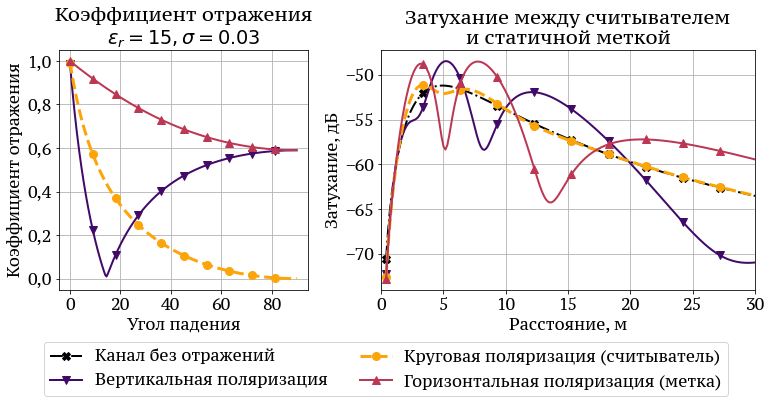

In [13]:
def plot_pathlosses(out: Union[Sequence[str], str] = ()):
    """
    Нарисовать график затухания в канале для разных поляризаций антенн.
    
    Args:
        out (str or list): имя файла (файлов), куда сохранить
    """
    ox = np.linspace(0.4, 30, 200)
    oa = np.linspace(0.1, 89.9, 200)
    
    y0 = [get_free_space_pathloss(x, 0, 0) for x in ox]
    yv = [get_pathloss(x, VERTICAL_POLARIZATION) for x in ox]
    yc = [get_pathloss(x, CIRCULAR_POLARIZATION) for x in ox]
    yh = [get_pathloss(x, HORIZONTAL_POLARIZATION) for x in ox]

    rv = [get_reflection(deg2rad(a), VERTICAL_POLARIZATION) for a in oa]
    rc = [get_reflection(deg2rad(a), CIRCULAR_POLARIZATION) for a in oa]
    rh = [get_reflection(deg2rad(a), HORIZONTAL_POLARIZATION) for a in oa]

    fig, (ax0, ax1) = plt.subplots(figsize=(11, 5), nrows=1, ncols=2, 
                                   gridspec_kw={'width_ratios': [1, 1.5]})
    
    label_0 = "Канал без отражений"
    label_h = "Горизонтальная поляризация (метка)"
    label_v = "Вертикальная поляризация"
    label_c = "Круговая поляризация (считыватель)"
    
    c0 = get_color(0)
    cv = get_color(0.2)
    ch = get_color(0.5)
    cc = get_color(0.8)

    props_0 = {'color': c0, 'linewidth': 2, 'linestyle': '-.',
               'marker': 'X', 'markersize': 8, 'markevery': 20}
    props_v = {'color': cv, 'linewidth': 2, 'linestyle': '-',
               'marker': 'v', 'markersize': 8, 'markevery': 20}
    props_h = {'color': ch, 'linewidth': 2, 'linestyle': '-',
               'marker': '^', 'markersize': 8, 'markevery': 20}
    props_c = {'color': cc, 'linewidth': 3, 'linestyle': '--',
               'marker': 'o', 'markersize': 8, 'markevery': 20}

    ax0.set_title("Коэффициент отражения\n" + 
                  r'$\epsilon_r = 15, \sigma = 0.03$')
    ax0.set_xlabel("Угол падения")
    ax0.set_ylabel("Коэффициент отражения")
    ax0.plot(oa, rv, label=label_v, **props_v)
    ax0.plot(oa, rc, label=label_c, **props_c)
    ax0.plot(oa, rh, label=label_h, **props_h)
    ax0.grid()

    ax1.set_title("Затухание между считывателем\nи статичной меткой")
    ax1.set_xlabel("Расстояние, м")
    ax1.set_ylabel("Затухание, дБ")
    ax1.plot(ox, y0, label=label_0, **props_0)
    ax1.plot(ox, yv, label=label_v, **props_v)
    ax1.plot(ox, yc, label=label_c, **props_c)
    ax1.plot(ox, yh, label=label_h, **props_h)
    ax1.grid()
    ax1.set_xlim((0, 30))


    fig.legend(*ax1.get_legend_handles_labels(), 
               loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    savefig(out)

plot_pathlosses(("ch2_pathloss.pdf", "ch2_pathloss.png"))

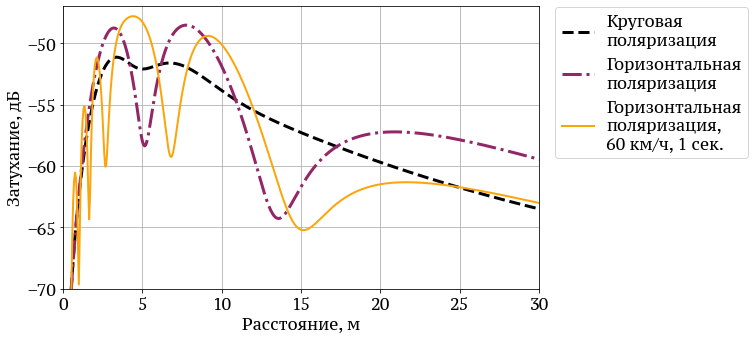

In [14]:
def plot_pathloss_with_doppler(out: Union[str, Sequence[str]] = ()) -> None:
    ox = np.linspace(0.4, 30, 500)
    
    yc = [get_pathloss(x, CIRCULAR_POLARIZATION) for x in ox]
    yh = [get_pathloss(x, HORIZONTAL_POLARIZATION) for x in ox]
    yh60 = [get_pathloss(x, HORIZONTAL_POLARIZATION, v=kmph2mps(60), t=1) 
            for x in ox]
    
    fig, ax = plt.subplots(figsize=(8, 5), nrows=1, ncols=1)
    
    ax.set_xlabel("Расстояние, м")
    ax.set_ylabel("Затухание, дБ")
    ax.plot(ox, yc, label="Круговая\nполяризация", 
            linestyle='--', linewidth=3, color=get_color(0))
    ax.plot(ox, yh, label="Горизонтальная\nполяризация", 
            linestyle='-.', linewidth=3, color=get_color(0.4))
    ax.plot(ox, yh60, label="Горизонтальная\nполяризация,\n60 км/ч, 1 сек.",
            linestyle='-', linewidth=2, color=get_color(0.8))
    ax.set_xlim((0, ox[-1]))
    ax.set_ylim((-70, -47))
    ax.grid()
    fig.legend(*ax.get_legend_handles_labels(), 
               loc='center right', bbox_to_anchor=(1.33, 0.74))
    plt.tight_layout()

    savefig(out)

plot_pathloss_with_doppler(("ch2_pathloss_3.png", "ch2_pathloss_3.pdf"))

## Расчет мощностей сигналов

Рассчитаем мощности сигналов, которые отражает метка и принимает считыватель.

In [15]:
def get_tag_rx(x: float, v: float, t: float, 
               tx: float = READER_TX_POWER) -> float:
    """Вычислить мощность сигнала, принятого меткой."""
    path_loss = get_pathloss(x, READER_POLARIZATION, v, t)
    pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    gain = READER_GAIN + TAG_GAIN
    return tx + path_loss + pol_loss + gain + READER_CABLE_LOSS

In [16]:
def get_tag_tx(rx: float):
    """Вычислить мощность сигнала, отраженного меткой."""
    return rx + TAG_BACKSCATTER_LOSS

In [17]:
def get_reader_rx(x: float, v: float, t: float, tx: float) -> float:
    """Вычислить мощность сигнала, принятого считывателем."""
    path_loss = get_pathloss(x, TAG_POLARIZATION, v, t)
    pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    gain = READER_GAIN + TAG_GAIN
    return tx + path_loss + pol_loss + gain + READER_CABLE_LOSS

Нам потребуется определять зоны, в которых метка получает сигнал, 
выше уровня ее чувствительности. Для этого определим функцию `find_high_zones()`, 
которая будет возвращать набор интервалов, внутри которых значение функции больше
граничного значения.

In [18]:
def find_zones(x: Sequence[float], y: Sequence[float], 
               bound: float, use_upper: bool = True) -> Sequence[Tuple[float, float]]:
    """
    Найти интервалы на X, внутри которых значение Y выше или ниже лимита.
    
    Например, если use_upper = True, то есть ищем интервалы выше лимита, то
    возвращает набор интервалов `[(x0, x1), (x2, x3), ...]`, таких, что:
    - для x[2n] <= x <= x[2n+1]: y(x) >= B
    - для x[2n+1] <= x <= x[2n+2]: y(x) <= B
    
    Размерности x и y должны совпадать.
    
    Args:
        x (sequence of float): последовательность аргументов
        y (sequence of float): последовательность значений
        bound (float): граничное значение
        use_upper (bool): если True, то ищем области, в которых значение выше
    
    Returns:
        intervals (sequence of tuples): последовательность интервалов
    """
    # Специально делаем так, чтобы изначально is_upper не совпадало с тем,
    # что будет в первой точке:
    is_upper = False
    x_left: Optional[float] = None
    intervals = []
    
    for i, (xi, yi) in enumerate(zip(x, y)):
        
        is_start_point = False
        is_end_point = False

        if (not is_upper or (use_upper and i == 0)) and yi >= bound:

            # Если выполняется равенство, нужно проверить, возрастает
            # ли функция в этой точке. Если нет - игнорируем.
            if yi > bound or i == len(x)-1 or y[i+1] >= bound:
                is_upper = True
                if use_upper:
                    is_start_point = True
                else:
                    is_end_point = True
                            
        elif (is_upper or (not use_upper and i == 0)) and yi <= bound:

            # Если выполняется равенство, нужно проверить, убывает
            # ли функция в этой точке. Если нет - игнорируем.
            if yi < bound or i == len(y)-1 or y[i+1] <= bound:
                is_upper = False
                if use_upper:
                    is_end_point = True
                else:
                    is_start_point = True
        
        if is_start_point:
            x_left = xi
        if is_end_point:
            intervals.append((x_left, xi))
            x_left = None
    
    # После цикла проверяем, не надо ли закрыть интервал.
    if x_left is not None:
        intervals.append((x_left, x[-1]))
        
    return intervals

Zones where tag is off:  [(0.0, 2.0202020202020203), (10.909090909090908, 20.0)]


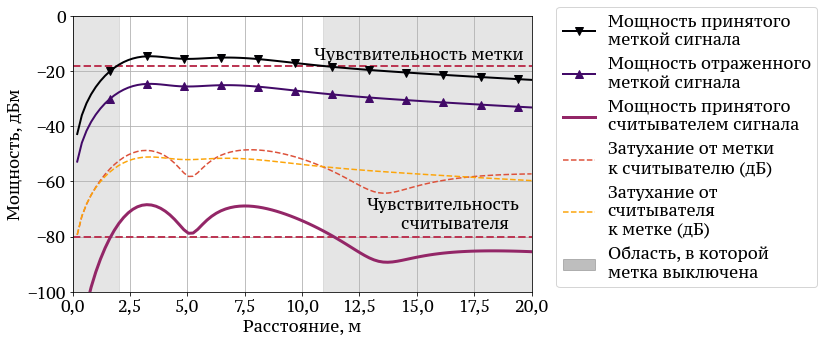

In [19]:
#
# БЮДЖЕТ СОЕДИНЕНИЙ
# -----------------
def plot_budget(out: Union[str, Sequence[str]] = ()):
    """
    Нарисовать график расчета бюджета соединений для стационарной мтеки.
    """
    ox = np.linspace(0, 20, 100)

    tag_pl = [get_pathloss(x, TAG_POLARIZATION) for x in ox]
    reader_pl = [get_pathloss(x, READER_POLARIZATION) for x in ox]
    tag_rx = [get_tag_rx(x, 0, 0) for x in ox]
    tag_tx = [get_tag_tx(rx) for rx in tag_rx]
    reader_rx = [get_reader_rx(x, 0, 0, tx) for (x, tx) in zip(ox, tag_tx)]

    y_min = -100
    y_max = 0

    fig, ax = plt.subplots(figsize=(8, 5), nrows=1, ncols=1)
    
    ax.plot(ox, tag_rx, label="Мощность принятого\nметкой сигнала",
            linewidth=2, linestyle='-', marker='v', markevery=8, markersize=8,
            color=get_color(0))
    ax.plot(ox, tag_tx, label="Мощность отраженного\nметкой сигнала",
            linewidth=2, linestyle='-', marker='^', markevery=8, markersize=8,
            color=get_color(0.2))
    ax.plot(ox, reader_rx, label="Мощность принятого\nсчитывателем сигнала",
            linewidth=3, color=get_color(0.4))
    ax.plot(ox, tag_pl, label="Затухание от метки\nк считывателю (дБ)",
            linestyle='--', color=get_color(0.6))
    ax.plot(ox, reader_pl, label="Затухание от\nсчитывателя\nк метке (дБ)",
            linestyle='--', color=get_color(0.8))

    # Нарисуем линии чувствительности метки и считывателя
    ax.hlines(y=TAG_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
              colors=get_color(0.5), linestyles='--', linewidths=2)
    ax.hlines(y=READER_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
              colors=get_color(0.5), linestyles='--', linewidths=2)

    ax.text(x=10.5, y=TAG_SENSITIVITY+2, s="Чувствительность метки", 
            fontdict={'style': 'italic'})
    ax.text(x=12.8, y=READER_SENSITIVITY+3, 
            s="Чувствительность\n        считывателя", 
            fontdict={'style': 'italic'})

    # Выделим области, в которых метка выключена
    tag_off_intervals = find_zones(ox, tag_rx, TAG_SENSITIVITY, use_upper=False)
    print("Zones where tag is off: ", tag_off_intervals)
    for interval in tag_off_intervals:
        ax.add_patch(patches.Rectangle(
            xy=(interval[0], y_min), 
            width=(interval[1] - interval[0]), 
            height=(y_max - y_min),
            fill=True, color='gray', alpha=0.2))    

    ax.set_xlim((0, ox[-1]))
    ax.set_ylim((y_min, y_max))
    ax.grid()
    ax.set_xlabel("Расстояние, м")
    ax.set_ylabel("Мощность, дБм")
    
    handles, labels = ax.get_legend_handles_labels()
    patch = patches.Patch(color='grey', alpha=0.5)
    handles.append(patch)
    labels.append("Область, в которой\nметка выключена")
    
    fig.legend(handles, labels, loc='center right', 
               bbox_to_anchor=(1.45, 0.57), ncol=1) 
    
    plt.tight_layout()
    savefig(out)

plot_budget(out=("ch2_link_budget.pdf", "ch2_link_budget.png"))

Эффект Доплера сильно влияет на затухание и, как следствие, на мощность сигналов, 
принятых меткой и считывателем. 

В следующем примере посмотрим, как меняется мощность при увеличении времени, 
прошеднего со включения считывателя. Метка будет двигаться со скоростью `60 км/ч`.


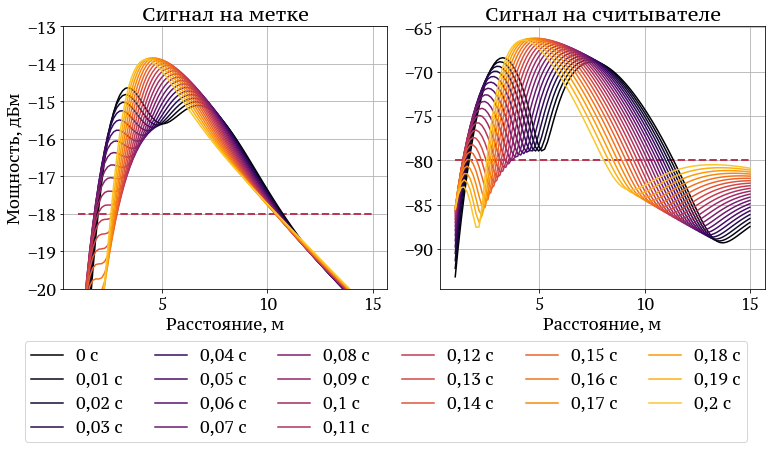

In [20]:
def plot_rx_power_doppler(out: Union[str, Sequence[str]] = ()) -> None:
    ox = np.linspace(1, 15, 100)
    ts = np.linspace(0, 0.2, 21)
    v = kmph2mps(60)
    fig, (ax0, ax1) = plt.subplots(figsize=(11, 5), nrows=1, ncols=2)
    
    for i, t in enumerate(ts):
        tag_rx = [get_tag_rx(x, v, t) for x in ox]
        tag_tx = [get_tag_tx(rx) for rx in tag_rx]
        rdr_rx = [get_reader_rx(x, v, t, tx) for (x, tx) in zip(ox, tag_tx)]
        
        color = get_color(i / (len(ts) * 1.1))
        
        ax0.plot(ox, tag_rx, label=f"{t:n} с", color=color)
        ax1.plot(ox, rdr_rx, color=color)
    
    ax0.set_ylabel("Мощность, дБм")
    for ax in (ax0, ax1):
        ax.grid()        
        ax.set_xlabel("Расстояние, м")
    
    ax0.set_ylim((-20, -13))
    
    ax0.set_title("Сигнал на метке")
    ax1.set_title("Сигнал на считывателе")

    ax0.hlines(y=TAG_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
               colors=get_color(0.5), linestyles='--', linewidths=2)
    ax1.hlines(y=READER_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
               colors=get_color(0.5), linestyles='--', linewidths=2)
    
    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', 
               bbox_to_anchor=(0.5, -0.28), ncol=6) 

    plt.tight_layout()
    savefig(out)


plot_rx_power_doppler(("ch2_rx_power_doppler.png", "ch2_rx_power_doppler.pdf"))

## Расчет битовой ошибки

Рассчитаем битовую ошибку и исследуем, как она зависит от параметров 
канала и эффекта Доплера.

Для расчета BER нужно знать отношение "сигнал-шум" (SNR) $\gamma$. 
Для более точных результатов лучше вместо простого SNR использовать
величину, учитывающую количество принятой энергии на бит $\acute{\gamma}$:

$$
\acute{\gamma} = \frac{m E_s}{N_0} \cos^2 \phi_s,
$$
где:

- $m$ - число символов на бит в ответах метки (1, 2, 4 или 8);
- $E_s$ - энергия на один символ;
- $N_0/2$ - спектральная плотность шума;
- $\phi_s$ - разность фазы сигнала и фазы приема.

Отношение $E_s / N_0$ можно выразить через SNR $\gamma$, длительность символа
$T_s$ и ширину полосы $B$ как $E_s / N_0 = \gamma T_s B$. Величину $\phi_s$
можно оценить как $\frac{1}{\sqrt{\gamma T_{pr} B}}$, где $T_{pr}$ - длина
преамбулы. Подставляя в форумулу, получаем:

$$
\acute{\gamma} \approx m \gamma T_s B \cos^2 \frac{1}{\sqrt{\gamma T_{pr} B}}
$$


Самая простая формула для расчета BER - канал AWGN. В нем BER рассчитывается так:

$$
P_{er} = 2 Q(\acute{\gamma}) [1 - Q(\acute{\gamma})]
$$

Эта формула слишком оптимистична, поэтому для расчета BER будем использовать формулу, 
полученную усреднением BER для канала AWGN по распределению Рэлея:

$$
BER = \frac{1}{2} - 
      \frac{1}{\sqrt{1 + \frac{1}{\acute{\gamma}}}} + 
      \frac{2}{\pi} \frac{\arctan{\sqrt{1 + \frac{1}{\acute{\gamma}}}}}{1 + \frac{1}{\acute{\gamma}}}.
$$

In [21]:
NOISE = w2dbm(dbm2w(READER_NOISE) + dbm2w(THERMAL_NOISE))

def get_trcal(tari: float) -> float:
    rtcal = tari * RTCAL_MUL
    return rtcal * TRCAL_MUL


def get_blf(trcal: float, dr: float = DR) -> float:
    return dr / trcal
    
    
def get_preamble(m: int, trcal: float, trext: bool = False,
                 dr: float = DR) -> float:
    if m == 1:
        n_bits = 18 if trext else 6
    else:
        n_bits = 22 if trext else 10
    return n_bits / get_blf(trcal, dr)


def get_raw_snr(rx: float) -> float:
    return pyradise.signal2noise(rx_power=rx, noise_power=NOISE)


def get_snr(rx: float, m: int, trcal: float, trext: bool = False,
            dr: float = DR) -> float:
    snr = get_raw_snr(rx)
    preamble = get_preamble(m, trcal, trext, dr)
    sync = pyradise.sync_angle(snr=snr, preamble_duration=preamble)
    return pyradise.snr_extended(
        snr=snr, 
        sync_phi=sync, 
        miller=m, 
        symbol_duration=(1 / get_blf(trcal, dr))
    )

In [22]:
def get_awgn_ber(snr: float) -> float:
    return pyradise.ber_over_awgn(snr=snr)


def get_ber(snr) -> float:
    return pyradise.ber_over_rayleigh(snr=snr)

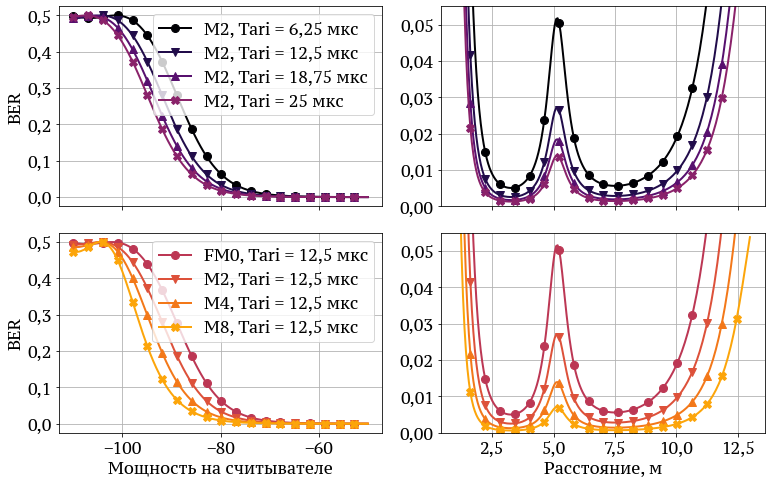

In [39]:
def plot_ber(out: Union[str, Sequence[str]] = ()):
    ox = np.linspace(1, 13, 200)
    basic_rx = np.linspace(-110, -50, 200)
    fig, ((ax0, ax1), (ax2, ax3)) = \
          plt.subplots(figsize=(11, 7), nrows=2, ncols=2, sharex='col')
    
    tag_rx = [get_tag_rx(x, 0, 0) for x in ox]
    tag_tx = [get_tag_tx(rx) for rx in tag_rx]
    rdr_rx = [get_reader_rx(x, 0, 0, tx) for (x, tx) in zip(ox, tag_tx)]
    
    all_tari = [6.25, 12.5, 18.75, 25]
    all_m = [1, 2, 4, 8]
    
    markers = ['o', 'v', '^', 'X']

    # Фиксируем M, варьируем Tari
    # ---------------------------
    m = 2
    m_name = "FM0" if m == 1 else f"M{m}"
    for ti, tari_us in enumerate(all_tari):
        tari = tari_us * 1e-6
        tari_name = f"{tari_us:n} мкс"
        trcal = get_trcal(tari)
        
        rdr_snr = [get_snr(rx, m, trcal) for rx in rdr_rx]
        rdr_ber = [get_ber(snr) for snr in rdr_snr]
        
        basic_snr = [get_snr(rx, m, trcal) for rx in basic_rx]
        basic_ber = [get_ber(snr) for snr in basic_snr]
        
        kws = {'linewidth': 2, 'marker': markers[ti], 
               'color': get_color(0.5 * ti / len(all_tari)), 
               'markevery': 10, 'markersize': 8}
        
        label = f"{m_name}, Tari = {tari_name}"
        ax0.plot(basic_rx, basic_ber, **kws, label=label)
        ax1.plot(ox, rdr_ber, **kws, label=label)
    
    # Фиксируем Tari, варьируем M
    # ---------------------------
    tari_us = 12.5
    tari = tari_us * 1e-6
    tari_name = f"{tari_us:n} мкс"
    trcal = get_trcal(tari)
    for mi, m in enumerate(all_m):
        m_name = "FM0" if m == 1 else f"M{m}"
        rdr_snr = [get_snr(rx, m, trcal) for rx in rdr_rx]
        rdr_ber = [get_ber(snr) for snr in rdr_snr]
        
        basic_snr = [get_snr(rx, m, trcal) for rx in basic_rx]
        basic_ber = [get_ber(snr) for snr in basic_snr]
        
        kws = {'linewidth': 2, 'marker': markers[mi], 
               'color': get_color(0.4 * mi / len(all_m) + 0.5),
               'markevery': 10, 'markersize': 8}
        
        label = f"{m_name}, Tari = {tari_name}"
        ax2.plot(basic_rx, basic_ber, **kws, label=label)
        ax3.plot(ox, rdr_ber, **kws, label=label)
        
    
    for ax in (ax0, ax1, ax2, ax3):
        ax.grid()
    
    for ax in (ax0, ax2):
        ax.set_ylabel("BER")
    
    ax2.set_xlabel("Мощность на считывателе")
    ax3.set_xlabel("Расстояние, м")
    for ax in (ax1, ax3):
        ax.set_ylim((0, 0.055))
        
    ax0.legend()
    ax2.legend()
    
#     fig.legend(*ax0.get_legend_handles_labels(), 
#                loc='lower center', bbox_to_anchor=(0.28, -0.2), ncol=1) 
    
#     fig.legend(*ax2.get_legend_handles_labels(), 
#                loc='lower center', bbox_to_anchor=(0.79, -0.2), ncol=1) 

    plt.tight_layout()
    savefig(out)


plot_ber(("ch2_ber.pdf", "ch2_ber.png"))

Теперь рассчитаем BER с учетом эффекта Доплера.

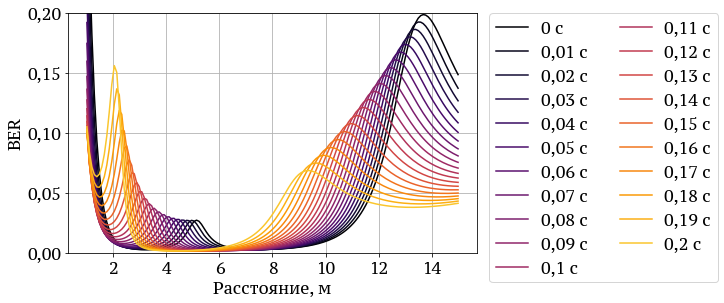

In [24]:
def plot_ber_doppler(m: int = 2, tari_us: float = 12.5, 
                     out: Union[str, Sequence[str]] = ()) -> None:
    ox = np.linspace(1, 15, 150)
    ts = np.linspace(0, 0.2, 21)
    v = kmph2mps(60)
    fig, ax = plt.subplots(figsize=(7, 4.5), nrows=1, ncols=1)
    
    tari = tari_us * 1e-6
    trcal = get_trcal(tari)
    
    for i, t in enumerate(ts):
        tag_rx = [get_tag_rx(x, v, t) for x in ox]
        tag_tx = [get_tag_tx(rx) for rx in tag_rx]
        rdr_rx = [get_reader_rx(x, v, t, tx) for (x, tx) in zip(ox, tag_tx)]
        
        rdr_snr = [get_snr(rx, m, trcal) for rx in rdr_rx]
        ber = [get_ber(snr) for snr in rdr_snr]
        
        color = get_color(i / (len(ts) * 1.1))
        ax.plot(ox, ber, label=f"{t:n} с", color=color)
    
    ax.grid()
    ax.set_ylabel("BER")
    ax.set_xlabel("Расстояние, м")
    ax.set_ylim((0, 0.2))
    
    # ax0.set_ylim((-20, -13))
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
               bbox_to_anchor=(1.46, 0.51), ncol=2) 
        
    plt.tight_layout()
    savefig(out)


plot_ber_doppler(out=("ch2_ber_doppler.png", "ch2_ber_doppler.pdf"))